In [1]:
import joblib
import numpy as np
import sys
from scipy import spatial
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import gettempdir
import seaborn as sns
from Bio import PDB
from Bio.PDB.DSSP import DSSP
from Bio.PDB import NeighborSearch
from Bio import SeqIO
from Bio.PDB import PDBList
import Bio.PDB.Polypeptide as Polypeptide
import itertools
from math import sqrt
import sklearn.metrics as metrics
from scipy.stats import pearsonr
import pprint
import os
import gzip
from sultan import Sultan
from retrieve_pdb import retrieve_pdb_file
import cmap
import tempfile


In [2]:
trrosetta= np.load('/home/fapatalano/Desktop/tesi/distpred/1a64.npz')
pdb_code= "1a64".upper()
pdbfile= f'/home/fapatalano/Desktop/tesi/dataset/pdb_file/{pdb_code}.pdb'

In [3]:
def get_pdb_coord(pdbfile, pdb_code):
    """

    :param pdbfile:
    :param pdb_code:
    :return: coords:
             list for each chain of residues in the PDB file without Hetero atoms
    """
    parser = PDB.PDBParser()
    structure = parser.get_structure(pdb_code, pdbfile)
    chains= PDB.Selection.unfold_entities(structure[0], 'C')
    coords = [PDB.Selection.unfold_entities(chains[0], 'R'),PDB.Selection.unfold_entities(chains[1], 'R')]
    return coords

pdb_coord=get_pdb_coord(pdbfile, pdb_code)

In [4]:
def trrosetta2maps(trrosetta, probcut=0.5, bin_step=0.5):

    """
    :param trrosetta:
    :param probcut:
    :param bin_step:
    :return:
    """

    a = trrosetta['dist']
    bins = np.array([2.25 + bin_step * i for i in range(36)])
    if len(a[0, 0, :]) != 37:
        raise Exception('ERROR! This is not a trRosetta prediction')
    D = np.full((len(a), len(a)), 20.0)  # res
    np.fill_diagonal(D, 0)
    for i in range(len(a)):
        for j in range(len(a[0])):
            maxprob_value = np.sum(a[i, j, 5:], axis=-1)
            if maxprob_value > probcut:
                D_slice = a[i, j, 1:]
                mean_dist = np.sum(np.multiply(bins, D_slice / np.sum(D_slice)))
                D[i, j] = mean_dist
    return D

def pdb2dmap(chains):
    """
    :param chains:
           list for each chain of residues in the PDB file without hetatom
    :return: pdb_map:
             numpy array filled with the true intrachain and interchain distances
    """

    residues_tot = chains[0] + chains[1]
    L = len(chains[0]) * 2
    pdb_map = np.full((L, L), np.nan)
    for i in residues_tot:
        for j in residues_tot:
            if i.resname == 'GLY' and j.resname == 'GLY':
                if i.has_id('CA') and j.has_id('CA') and i.id[1] - 1 < L and j.id[1] - 1 < L:
                    pdb_map[i.id[1] - 1, j.id[1] - 1] = i["CA"] - j["CA"]
            elif i.resname == 'GLY' and j.has_id('CB'):
                if i.has_id('CA') and i.id[1] - 1 < L and j.id[1] - 1 < L: pdb_map[i.id[1] - 1, j.id[1] - 1] = i["CA"] - j["CB"]
            elif j.resname == 'GLY' and i.has_id('CB'):
                if j.has_id('CA') and i.id[1] - 1 < L and j.id[1] - 1 < L: pdb_map[i.id[1] - 1, j.id[1] - 1] = i["CB"] - j["CA"]
            elif i.has_id('CB') and j.has_id('CB') and i.id[1] - 1 < L and j.id[1] - 1 < L: pdb_map[i.id[1] - 1, j.id[1] - 1] = i["CB"] - j["CB"]
    # pdb_map[pdb_map > 20] = np.nan
    return pdb_map


pdb_map = pdb2dmap(pdb_coord)
trrosetta_map = trrosetta2maps(trrosetta)
tot_pred_intra_distances = trrosetta_map.flatten().tolist()


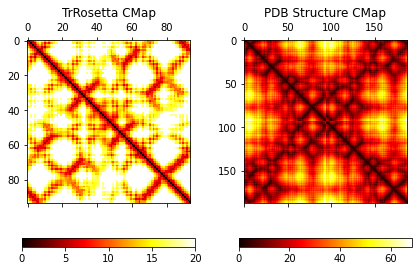

In [5]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
plot1 = ax1.matshow(trrosetta_map, cmap="hot")
plot2 = ax2.matshow(pdb_map, cmap="hot")
ax1.title.set_text('TrRosetta CMap')
ax2.title.set_text('PDB Structure CMap')
fig.colorbar(plot1, ax=ax1, orientation='horizontal')
fig.colorbar(plot2, ax=ax2, orientation='horizontal')
fig.tight_layout()

In [6]:
def get_true_intrachain_dist(pdb_cmap,coords):
    """
    :param pdb_cmap:
            PDB coordinates
    :return: distances: intra-chain distances obtained from the PDB file
        Intrachain contact between two residues i and j is said to exist if the Euclidean distance between the respective C beta
        (C alpha for glycine) atoms of residues i and j is less than or equal to 12.0 Å --> uguzzoni et al
    """

    L = len(coords[0])
    distance_matrix = pdb_cmap[:L, :L]
    distance_matrix[distance_matrix > 8] = np.nan
    return distance_matrix

true_intra_map = get_true_intrachain_dist(pdb_map,pdb_coord)

In [7]:
def get_interacting_residues(model, r_cutoff=6):
    """
    Return residue-residue interactions between all chains in the model.

    Parameters
    ----------
    :param r_cutoff:
    :param model:

    Returns
    -------
    dict
        A dictionary of interactions between chains i (0..n-1) and j (i+1..n).
        Keys are (chain_idx, chain_id, residue_idx, residue_resnum, residue_amino_acid) tuples.
        (e.g. (0, 'A', 0, '0', 'M'), (0, 1, '2', 'K'), ...)
        Values are a list of tuples having the same format as the keys.

    Examples
    --------
    You can reverse the order of keys and values like this::

        complement = dict()
        for key, values in get_interacting_chains(model):
            for value in values:
                complement.setdefault(value, set()).add(key)


    You can get a list of all interacting chains using this command::

        {(key[0], value[0])
         for (key, values) in get_interacting_chains(model).items()
         for value in values}


    """
    interactions_between_chains = dict()
    atoms_c2 = PDB.Selection.unfold_entities(model[1], 'A')
    ns = PDB.NeighborSearch(atoms_c2)

    # Residue 1
    for residue_1 in model[0]:
        interacting_residues = set()
        for atom_1 in residue_1: interacting_residues.update(ns.search(atom_1.get_coord(), r_cutoff, 'R'))
        # ns search return a list of atoms at distance x from the target atom

        # Residue 2
        interacting_residue_ids = []
        for residue_2 in interacting_residues:
            interacting_residue_ids.append(residue_2)
            if interacting_residue_ids:
                interactions_between_chains.setdefault(residue_1, set()).update(interacting_residue_ids)
    return interactions_between_chains

interacting_residue = get_interacting_residues(pdb_coord, r_cutoff=6)
def get_true_inter_distances(interactions_between_chains, coords):
    """
    :param coords:
    :param interactions_between_chains:
    :return: inter
    """
    L = len(coords[0])
    inter = np.full((L,L), np.nan)
    for key, values in interactions_between_chains.items():
        for value in values:
            if key.resname == 'GLY' and value.resname == 'GLY':
                i =  key.id[1]-1
                j = (value.id[1] -1) - len(coords[0])
                if i < L and j < L : inter[i, j]= key['CA'] - value['CA']
            elif key.resname == 'GLY' and value.has_id('CB'):
                i =  key.id[1]-1
                j = (value.id[1] -1) - len(coords[0])
                if i < L and j < L : inter[i, j]= key['CA'] - value['CB']
            elif value.resname == 'GLY' and key.has_id('CB'):
                i =  key.id[1]-1
                j = (value.id[1] -1) - len(coords[0])
                if i < L and j < L : inter[i, j]= key['CB'] - value['CA']
            elif key.has_id('CB') and value.has_id('CB'):
                i =  key.id[1]-1
                j = (value.id[1] -1) - len(coords[0])
                if i < L and j < L : inter[i, j]= key['CB'] - value['CB']

    return inter
inter_distances = get_true_inter_distances(interacting_residue,pdb_coord)
print('Total number of interchain contacts',len(np.where(~np.isnan(inter_distances))[0]))
pprint.pprint(interacting_residue)

Total number of interchain contacts 399
{<Residue GLY het=  resseq=1 icode= >: {<Residue ALA het=  resseq=181 icode= >,
                                        <Residue LEU het=  resseq=182 icode= >,
                                        <Residue ASP het=  resseq=183 icode= >,
                                        <Residue LEU het=  resseq=184 icode= >},
 <Residue THR het=  resseq=2 icode= >: {<Residue LEU het=  resseq=182 icode= >,
                                        <Residue ASP het=  resseq=183 icode= >,
                                        <Residue LEU het=  resseq=184 icode= >,
                                        <Residue ARG het=  resseq=185 icode= >},
 <Residue VAL het=  resseq=3 icode= >: {<Residue LEU het=  resseq=182 icode= >,
                                        <Residue ASP het=  resseq=183 icode= >,
                                        <Residue LEU het=  resseq=184 icode= >,
                                        <Residue ARG het=  resseq=185 icode= >

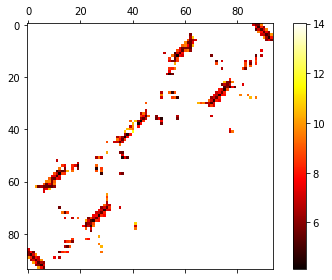

In [8]:
fig,(ax1) = plt.subplots(ncols=1)
plot1 = ax1.matshow(inter_distances, cmap="hot")
fig.colorbar(plot1, ax=ax1)
fig.tight_layout()

In [9]:
df = pd.DataFrame(trrosetta_map.flatten(),columns=['distance'],index=list(itertools.product(range(len(trrosetta_map)), repeat=2)))
df["type of contact"] = 'no contact'

In [10]:
true_contact= np.where(~np.isnan(true_intra_map))
listOfCoordinates= list(zip(true_contact[0], true_contact[1]))
for coord in listOfCoordinates:
    if coord in df.index:
        df.loc[[coord],'type of contact']= 'intrachain'

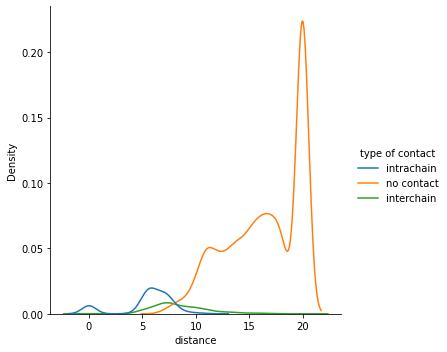

In [11]:
interchain_contact = np.where(~np.isnan(inter_distances))
listOfCoordinates= list(zip(interchain_contact[0], interchain_contact[1]))
for coord in listOfCoordinates:
    if coord in df.index:
        df.loc[[coord],'type of contact']= 'interchain'

sns.displot(data=df, x="distance", hue="type of contact", kind="kde")

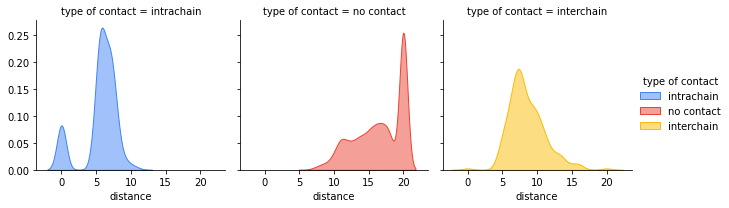

In [13]:
g = sns.FacetGrid(df,
                  col="type of contact",
                  hue="type of contact",
                  palette=['#4285F4','#EA4335','#FBBC05','#34A853']
                 )
g.map(sns.kdeplot, "distance", fill=True, shade=True, alpha=.5)
g.add_legend()
plt.savefig('/home/fapatalano/Desktop/tesi/results/images/distribution.pdf')